# Wavelets and sweeps

This notebook looks at the convolutional model of a seismic trace — first with an impulse-type wavelet, such as a Ricker — then with a simulated Vibroseis sweep. 

First, the usual preliminaries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load geophysical data

In [2]:
import lasio
l30 = lasio.read('../data/L-30.las')

Compute acoustic impedance.

We'll take every 24th point as a (very) approximate basis change, from 0.1524 m to about 1 ms. 

In [3]:
dt = l30.curves['DT'].data
rhob = l30.curves['RHOB'].data
ai = rhob * 1000000/dt
ai = ai[::6]

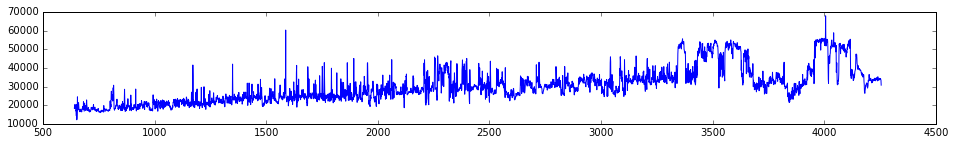

In [4]:
plt.figure(figsize=(16, 2))
plt.plot(ai)
plt.show()

Compute the reflection coefficients.

In [5]:
rc = (ai[1:] - ai[:-1]) / (ai[1:] + ai[:-1])
rc[np.isnan(rc)] = 0

## Impulsive wavelet

Convolve with a wavelet.

In [6]:
def ricker(f, length=0.128, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y
 
f = 30
t, w = ricker(f)

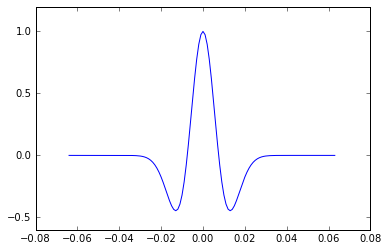

In [7]:
plt.plot(t, w)
plt.show()

In [8]:
syn = np.convolve(rc, w, mode='same')

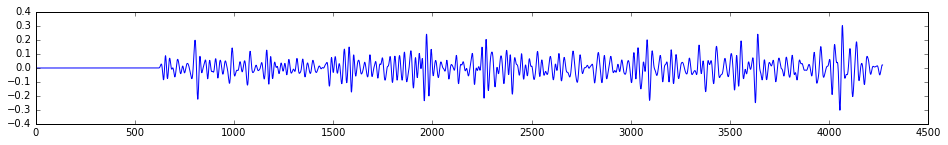

In [9]:
plt.figure(figsize=(16,2))
plt.plot(syn)
plt.show()

If we are recording with dynamite or even an airgun, this might be an acceptable model of the seismic. But if we're using Vibroseis, things get more complicated.

## The Vibroseis sweep

[Read more about vibroseis 'wavelets' and deconvolution](http://csegrecorder.com/articles/view/vibroseis-deconvolution-an-example-from-pikes-peak-saskatchewan). 

In [10]:
from scipy.signal import chirp

duration = 3
dt = 0.001
t = np.arange(0, duration , dt) 

sweep = chirp(t, 4, duration, 60)

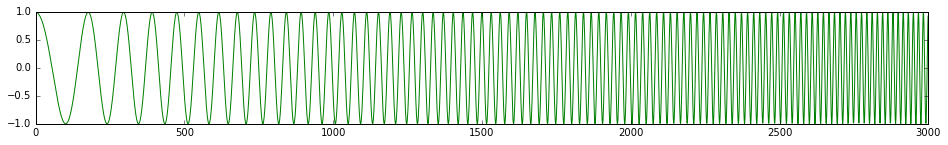

In [15]:
plt.figure(figsize=(16,2))
plt.plot(sweep, 'g')
plt.show()

The sudden displacement is unphysical. Let's apply a [Tukey window](https://en.wikipedia.org/wiki/Window_function#Tukey_window) so the sweep can ramp up and down in amplitude.

In [18]:
from scipy.signal import tukey
window = tukey(sweep.size, alpha=0.2)  # alpha=0.1: taper 10% of the signal.
sweep *= window

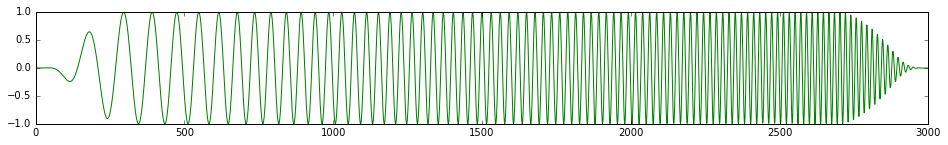

In [19]:
plt.figure(figsize=(16,2))
plt.plot(sweep, 'g')
plt.show()

## Model a field recording

To see what we get from the earth, we can convolve this with the reflectivity:

In [20]:
field = np.convolve(rc, sweep)

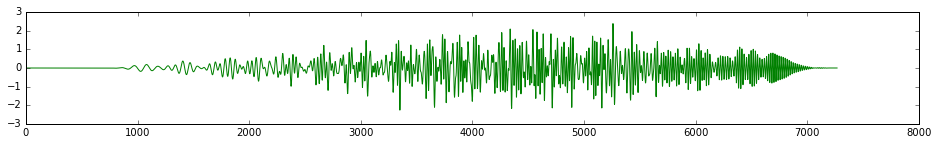

In [21]:
plt.figure(figsize=(16,2))
plt.plot(field, 'g')
plt.show()

Nasty.

## Correlation

It turns out that we can correlate this recorded trace with the sweep to get the 'impulsive' equivalent. For this reason, the recorded sweep is usually stored in the SEGY file, perhaps as an extra trace.

Note that this operation is the same as convolving with the timer-reversed sweep:

    correlated = np.convolve(field, sweep[::-1], mode='valid')

But we'll use correlation:

In [22]:
correlated = np.correlate(field, sweep, mode='valid')

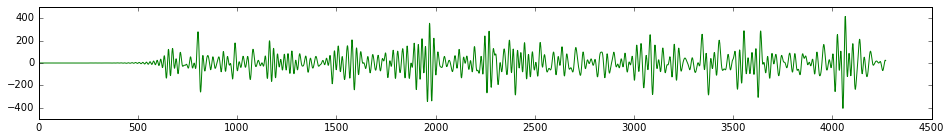

In [23]:
plt.figure(figsize=(16,2))
plt.plot(correlated, 'g')
plt.show()

## The Klauder wavelet

When we want to forward model a Vibroseis trace, we can produce an impulsive wavelet that is equivalent to the sweep by correlating it with itself. (Autocorrelation is the same as convolution with the sweep's own time-reverse.)

In [24]:
wavelet = np.correlate(sweep, sweep, mode='same')

As before, this is the same as convolution with its time-reversed self:

In [25]:
np.allclose(wavelet, np.convolve(sweep, sweep[::-1], mode='same'))

True

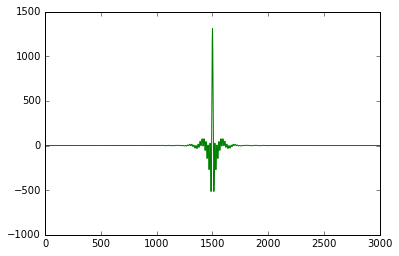

In [26]:
plt.plot(wavelet, 'g')
plt.show()

This wavelet is way too long. Let's crop it and window:

In [27]:
wavelet = wavelet[1200:1800]
wavelet *= np.hamming(600)

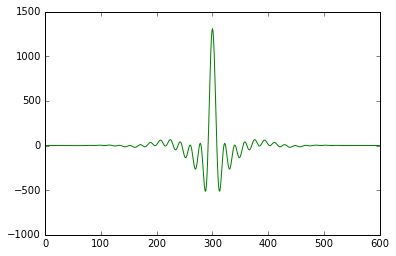

In [28]:
plt.plot(wavelet, 'g')
plt.show()

In [29]:
wavelet = wavelet / np.amax(wavelet)
syn_vibe = np.convolve(rc, wavelet, mode='same')

We can compare this trace to the one we 'recorded' with a Ricker wavelet.

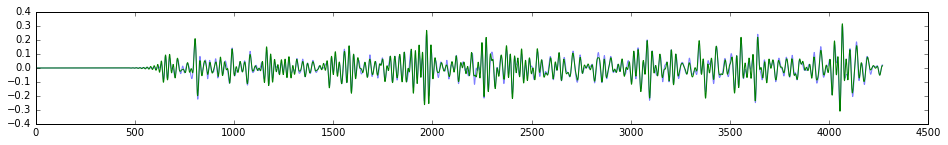

In [30]:
plt.figure(figsize=(16,2))
plt.plot(syn, alpha=0.5)
plt.plot(syn_vibe)
plt.show()

Let's zoom in a bit so we can see it:

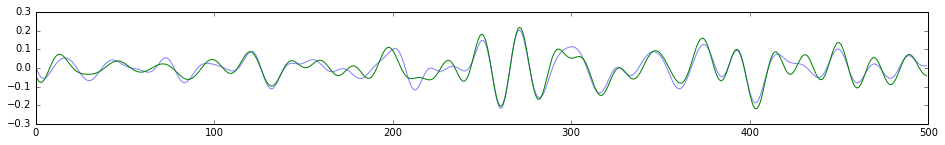

In [31]:
plt.figure(figsize=(16,2))
plt.plot(syn[2000:2500], alpha=0.5)
plt.plot(syn_vibe[2000:2500])
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>